In [1]:
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

np.set_printoptions(linewidth=200)
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
imageWidth = 512    
imageHeight = 512                                         
guidance_scale = 8                                                             
model_path = "segmind/tiny-sd" 

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
scheduler = LMSDiscreteScheduler.from_pretrained(model_path, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet").to(torch_device)
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae").to(torch_device)

In [3]:
def get_text_embeddings(prompt, tokenizer=tokenizer, text_encoder=text_encoder, torch_device=torch_device, batch_size=1, negative_prompt=""):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return text_embeddings

In [4]:
def generate_latents(seed, height=imageHeight, width=imageWidth, torch_device=torch_device, unet=unet, batch_size=1):
    generator = torch.Generator().manual_seed(int(seed))
    
    latents = torch.randn(
      (batch_size, unet.config.in_channels, height // 8, width // 8),
      generator=generator,
    ).to(torch_device)

    return latents

In [5]:
def convert_to_pil_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [6]:
def generate_images(latents, text_embeddings, num_inference_steps, unet=unet, guidance_scale=guidance_scale, vae=vae, scheduler=scheduler, intermediate=False):
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    images = []
    
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        if intermediate:
            Latents = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(Latents).sample
            images.append(convert_to_pil_image(image))

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    if not intermediate:
        Latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(Latents).sample
        images = convert_to_pil_image(image)

    return images

In [7]:
def display_negative_images(prompt, seed, num_inference_steps, intermediate=False, negative_prompt=""):
    text_embeddings = get_text_embeddings(prompt)
    text_embeddings_neg = get_text_embeddings(prompt, negative_prompt=negative_prompt)

    latents = generate_latents(seed)

    images = generate_images(latents, text_embeddings, num_inference_steps, intermediate=intermediate)
    images_neg = generate_images(latents, text_embeddings_neg, num_inference_steps, intermediate=intermediate)
    return images, images_neg

In [14]:
prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k" 
negative_prompt = "white"                                                       
num_inference_steps = 8                                                        
seed = 69420  

poke = False
intermediate = False                           
pokeX, pokeY = 256, 256                                                         
pokeHeight, pokeWidth = 128, 128    

In [15]:
images, images_neg = display_negative_images(prompt, seed, num_inference_steps, negative_prompt=negative_prompt)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

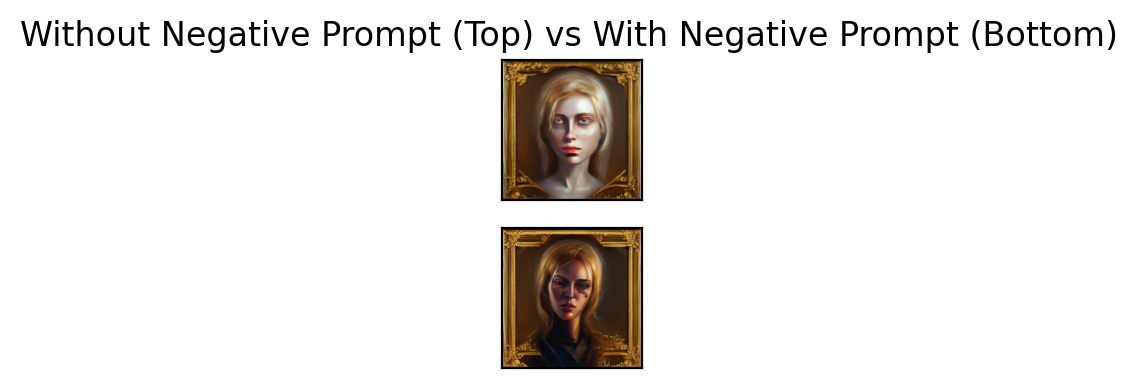

In [17]:
fig, ax = plt.subplots(2, 1, dpi=200, figsize=(1, 2))
fig.suptitle("Without Negative Prompt (Top) vs With Negative Prompt (Bottom)")
ax[0].imshow(images)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(images_neg)
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()